In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,FunctionTransformer,LabelEncoder,PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from mixed_naive_bayes import MixedNB
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,accuracy_score,confusion_matrix
import pickle
import re
import scipy.stats as ss

# 1.Problem Statement
Predict the outcome of the drugs that might be accurate for the patient.

# 2.Data Collection

In [5]:
data =pd.read_csv(r"C:\Users\Pavan Kalyan\Desktop\AI - Artifical Intelligence\Naive Bayes\DRUG prediction project\drug200.csv")

In [6]:
df = data.copy()

In [ ]:
df.head(2)

# 3.Basic EDA

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [9]:
df.shape

(200, 6)

In [10]:
df.duplicated().sum()

0

In [11]:
print(df['Sex'].unique(),end='\n\n')
print(df['BP'].unique(),end='\n\n')
print(df['Cholesterol'].unique(),end='\n\n')
print(df['Drug'].unique(),end='\n\n')


['F' 'M']

['HIGH' 'LOW' 'NORMAL']

['HIGH' 'NORMAL']

['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']



In [12]:
print(df['Na_to_K'].min())

6.269


In [13]:
df.describe(include ='all')

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
count,200.000000,200,200,200,200.000000,200
unique,NaN,2,3,2,NaN,5
top,NaN,M,HIGH,HIGH,NaN,DrugY
freq,NaN,104,77,103,NaN,91
mean,44.315000,NaN,NaN,NaN,16.084485,NaN
std,16.544315,NaN,NaN,NaN,7.223956,NaN
min,15.000000,NaN,NaN,NaN,6.269000,NaN
25%,31.000000,NaN,NaN,NaN,10.445500,NaN
50%,45.000000,NaN,NaN,NaN,13.936500,NaN
75%,58.000000,NaN,NaN,NaN,19.380000,NaN


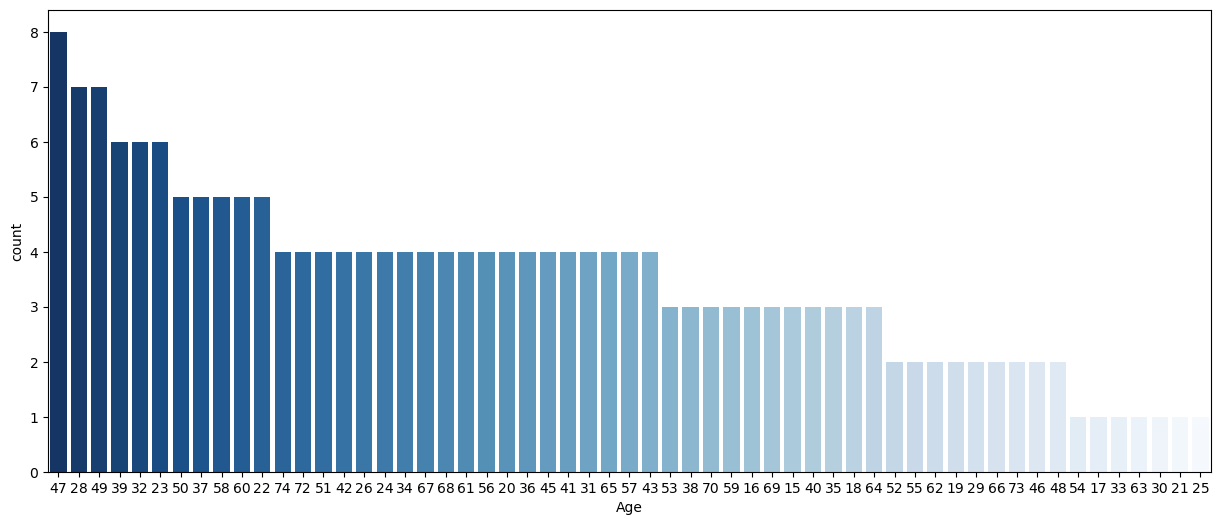

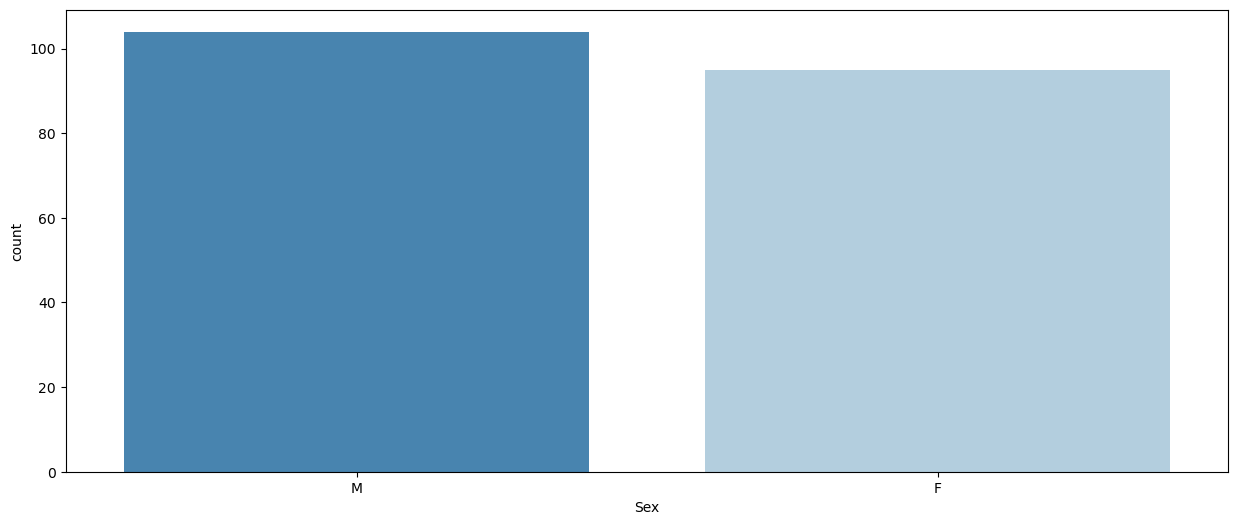

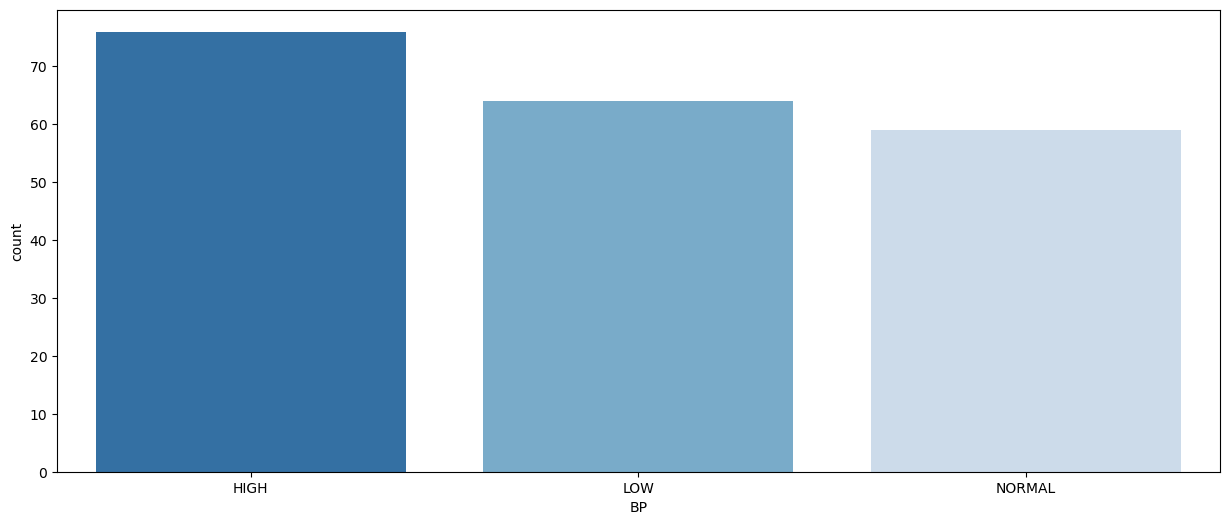

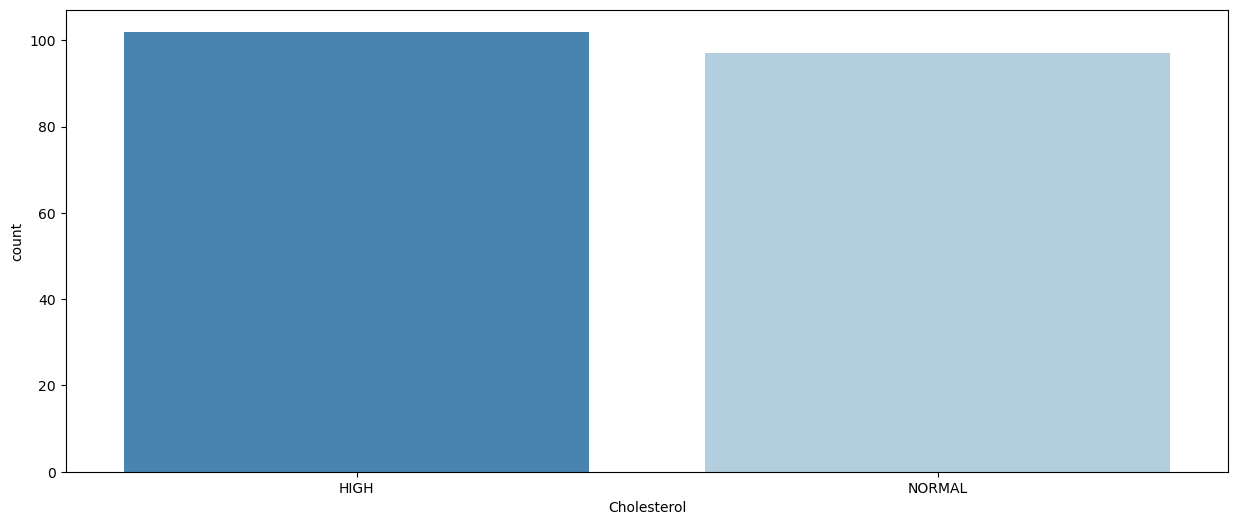

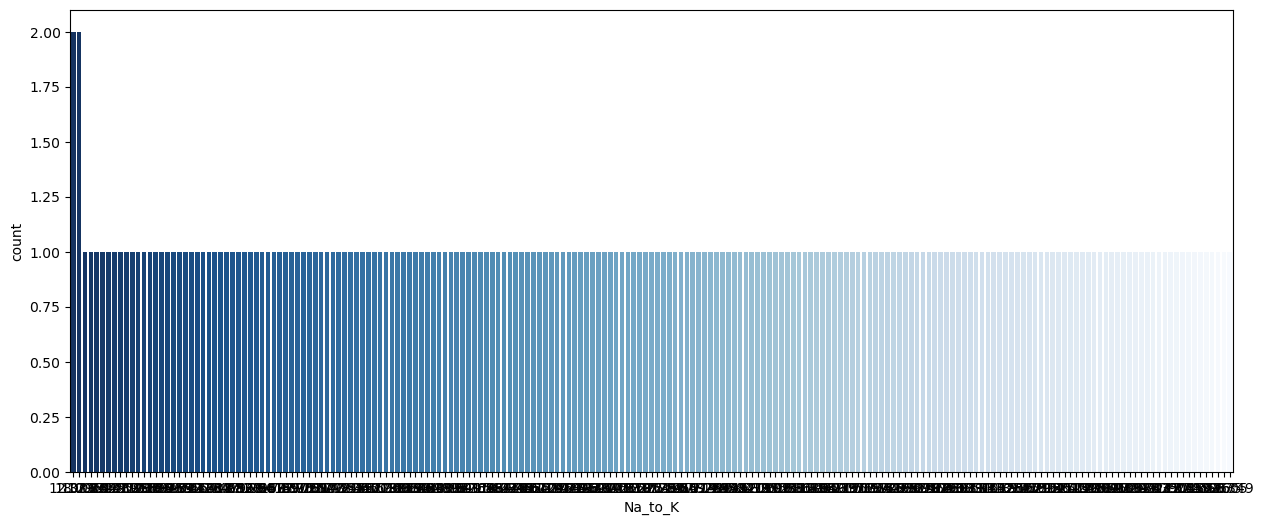

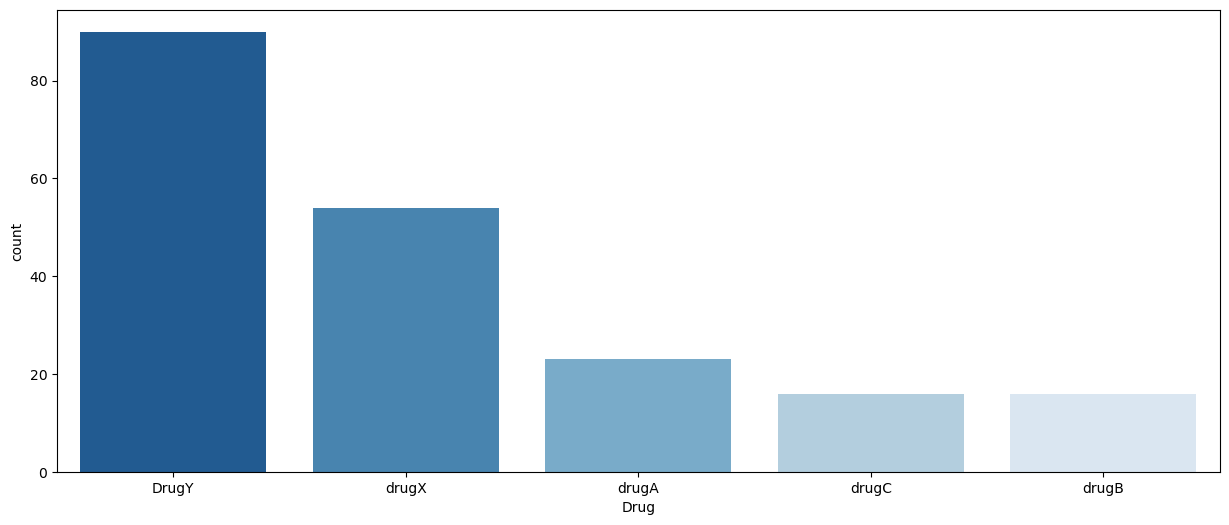

In [14]:
for i in list(df.columns):
    ax = plt.subplots(1,1, figsize=(15, 6))
    sns.countplot(x = df[i][1:],data=df.iloc[1:], order=df[i][1:].value_counts().index, palette='Blues_r')


# 4.Data Preprocessing

In [15]:
df.head(2)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC


In [16]:
# Feature variables
feature_var = df.iloc[:,0:-1]
feature_var

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,F,HIGH,HIGH,25.355
1,47,M,LOW,HIGH,13.093
2,47,M,LOW,HIGH,10.114
3,28,F,NORMAL,HIGH,7.798
4,61,F,LOW,HIGH,18.043
...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567
196,16,M,LOW,HIGH,12.006
197,52,M,NORMAL,HIGH,9.894
198,23,M,NORMAL,NORMAL,14.020


In [17]:
# Class variable
class_var = df.iloc[:,-1]
class_var

0      DrugY
1      drugC
2      drugC
3      drugX
4      DrugY
       ...  
195    drugC
196    drugC
197    drugX
198    drugX
199    drugX
Name: Drug, Length: 200, dtype: object

In [18]:
# Spliting the Dataset into Train and Test
x_train,x_test,y_train,y_test =train_test_split(feature_var,class_var,test_size=0.2,random_state=2,stratify=class_var)

In [19]:
x_train.head()

,Age,Sex,BP,Cholesterol,Na_to_K
76,36,F,HIGH,HIGH,11.198
24,33,F,LOW,HIGH,33.486
128,47,M,LOW,NORMAL,33.542
198,23,M,NORMAL,NORMAL,14.020
178,39,M,NORMAL,HIGH,15.969


# 5.EDA

In [20]:
eda_df = pd.concat([x_train,y_train],axis =1)
eda_df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
76,36,F,HIGH,HIGH,11.198,drugA
24,33,F,LOW,HIGH,33.486,DrugY
128,47,M,LOW,NORMAL,33.542,DrugY
198,23,M,NORMAL,NORMAL,14.020,drugX
178,39,M,NORMAL,HIGH,15.969,DrugY
...,...,...,...,...,...,...
169,20,F,HIGH,HIGH,11.262,drugA
107,42,M,LOW,HIGH,20.013,DrugY
8,60,M,NORMAL,HIGH,15.171,DrugY
161,57,F,HIGH,NORMAL,9.945,drugB


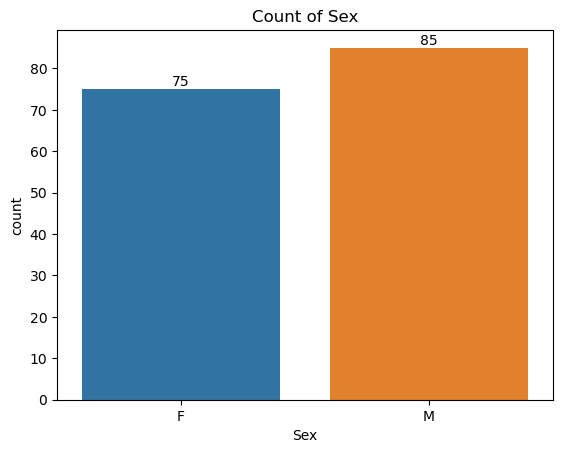

In [21]:
ax = sns.countplot(data = eda_df,x = 'Sex')
for y in ax.containers:
    ax.bar_label(y)
plt.title('Count of Sex')
plt.show()

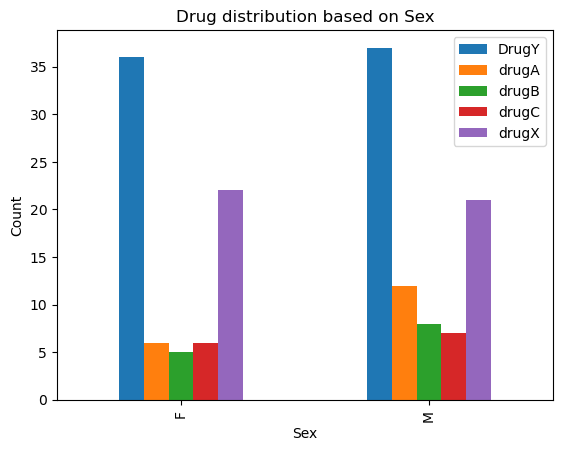

In [22]:
groupby1 = eda_df.groupby(['Sex','Drug']).size().unstack()
ax = groupby1.plot(kind ='bar')
ax.legend()
ax.set_title('Drug distribution based on Sex')
ax.set_ylabel('Count')
plt.show()

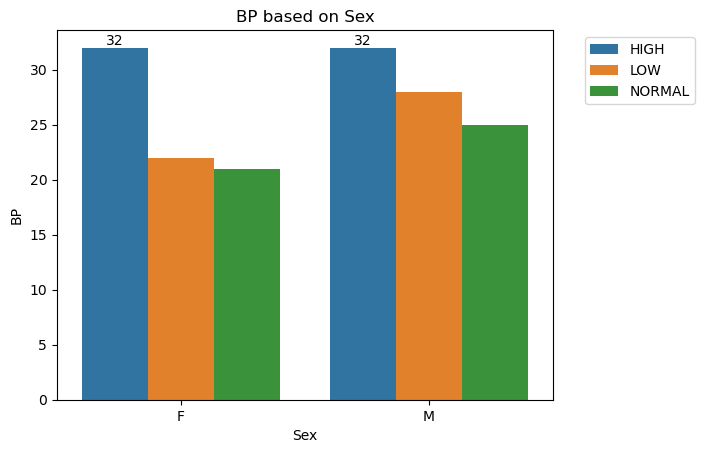

In [23]:
ax =sns.countplot(data = eda_df,x = 'Sex',hue = 'BP')
plt.title('BP based on Sex')
plt.ylabel('BP')
ax.bar_label(ax.containers[0])
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Above Countplot Both Male & Female have High BP of 32 

In [24]:
high_bp = eda_df[eda_df['BP']=='HIGH']

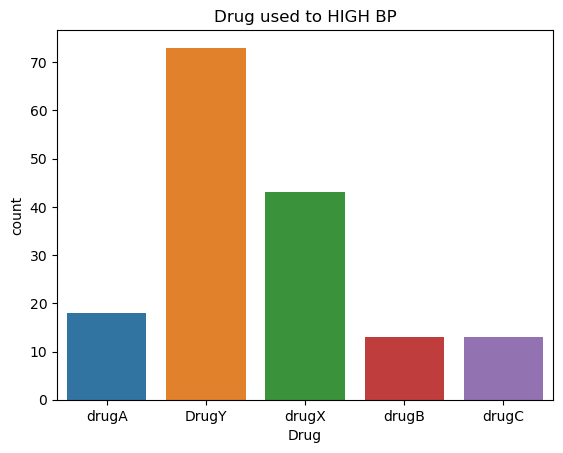

In [25]:
sns.countplot(high_bp,x =eda_df['Drug'] )
plt.title("Drug used to HIGH BP")
plt.show()

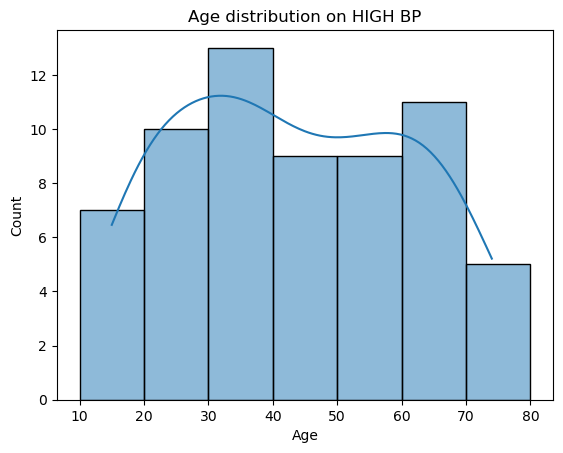

In [26]:
sns.histplot(data = high_bp,bins =[10,20,30,40,50,60,70,80],x = 'Age',kde = True)
plt.title('Age distribution on HIGH BP')
plt.show()

In [27]:
high_cholestrol = eda_df[eda_df['Cholesterol']=='HIGH']

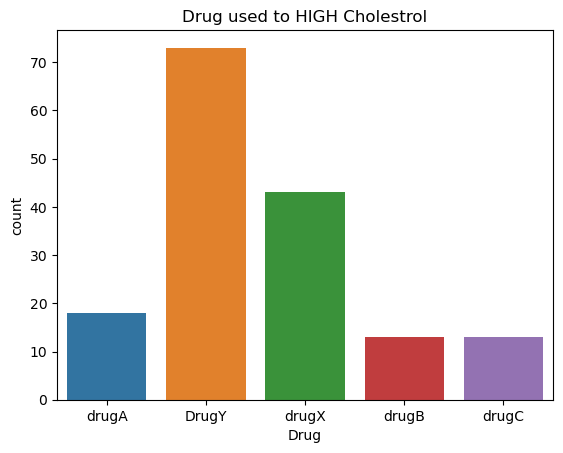

In [28]:
sns.countplot(high_cholestrol,x =eda_df['Drug'] )
plt.title("Drug used to HIGH Cholestrol")
plt.show()

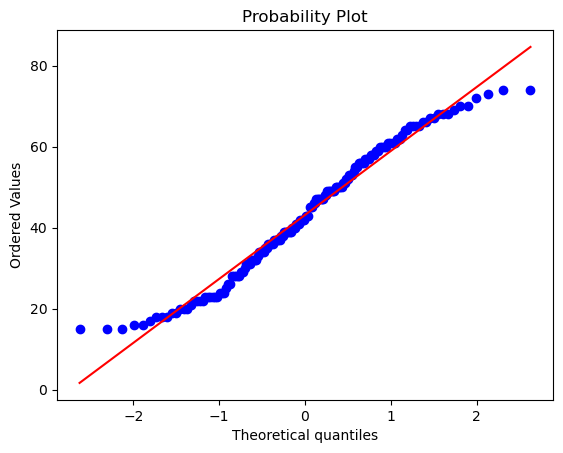

In [29]:
# Numerical Columns - Age,Na_to_K
# Numerical columns should normal or Guassian Distribution. If not, use Mathematical Transformers like Functional_Transformer,PowerTransformer
ss.probplot(x_train['Age'],dist = 'norm',fit =True,plot = plt)
plt.show()

In [30]:
# Uding Log of Age
ft =FunctionTransformer(func= np.log)
Age_log =ft.fit_transform(x_train['Age'])

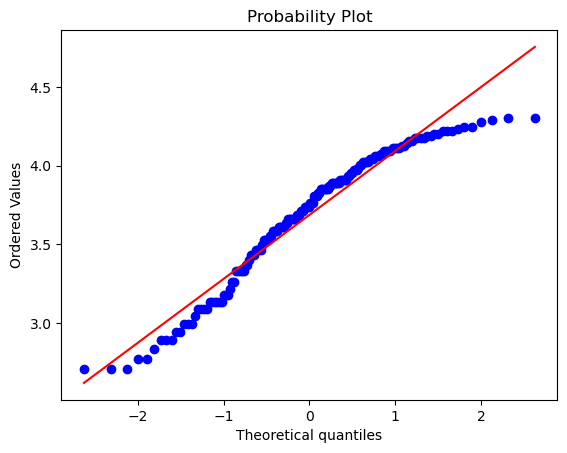

In [31]:
ss.probplot(Age_log,dist = 'norm',fit =True,plot = plt)
plt.show()

<Axes: xlabel='Age', ylabel='Density'>

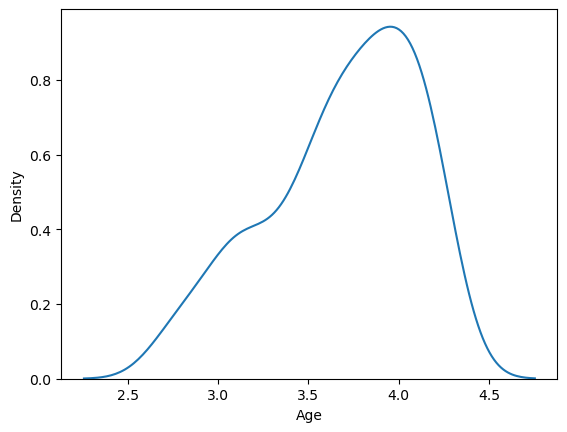

In [32]:
sns.kdeplot(Age_log)

In [33]:
# Using square to Age columnn values
ft =FunctionTransformer(func = np.square)
Age_sq = ft.fit_transform(x_train['Age'])

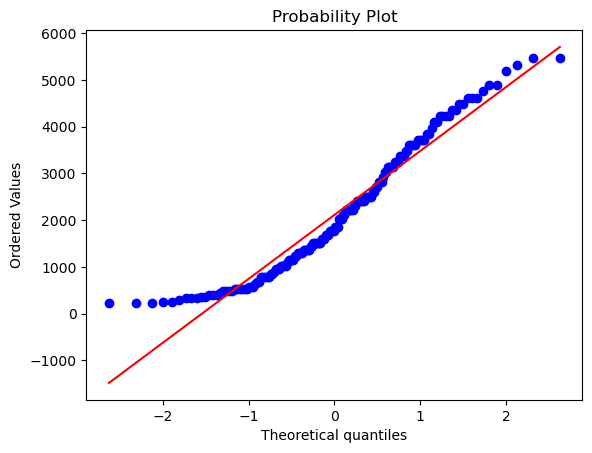

In [34]:
ss.probplot(Age_sq,dist = 'norm',fit =True,plot = plt)
plt.show()

In [35]:
# Reciprocal of Age Values
def reci(x):
    return 1/x

In [36]:
ft=FunctionTransformer(func=reci)
reci_age=ft.fit_transform(x_train["Age"])

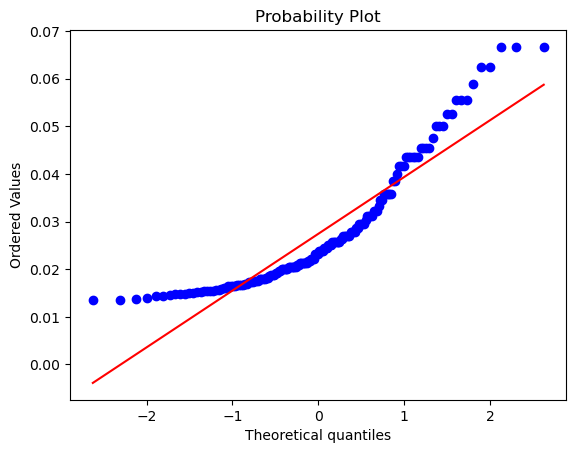

In [37]:
ss.probplot(reci_age,dist = 'norm',fit =True,plot = plt)
plt.show()

In [38]:
# square_root of Age column values
ft = FunctionTransformer(func=np.sqrt)
Age_sqt = ft.fit_transform(x_train['Age'])

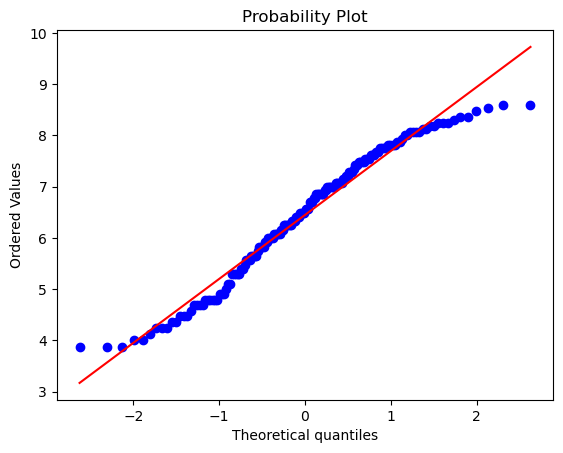

In [39]:
ss.probplot(Age_sqt,dist = 'norm',fit =True,plot = plt)
plt.show()

In [40]:
pf = PowerTransformer(method='box-cox')
Age_bc =pf.fit_transform(x_train[['Age']])

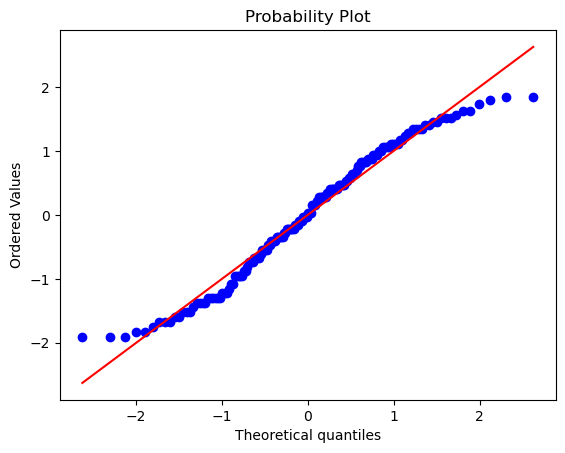

In [41]:
ss.probplot(Age_bc.flatten(),dist = 'norm',fit =True,plot = plt)
plt.show()

In [42]:
pf = PowerTransformer(method='yeo-johnson')
Age_yj =pf.fit_transform(x_train[['Age']])

In [ ]:
ss.probplot(Age_yj.flatten(),dist = 'norm',fit =True,plot = plt)
plt.show()

In [ ]:
sns.kdeplot(Age_yj)

# 6.Feature Extraction or Feature Engineering

In [ ]:
# Class labels convert into real values using Label Encoding
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [ ]:
lb.classes_

In [ ]:
x_train = x_train.astype({'BP':'category','Cholesterol':'category'})

In [ ]:
x_train.info()

In [ ]:
numerical_data = x_train.select_dtypes(include=['int64','float64'])
nomial_data = x_train.select_dtypes(include=['object'])
ordinal_data = x_train.select_dtypes(include=['category'])

In [ ]:
ordinal_data.columns

In [ ]:
x_train["BP"].value_counts()

In [ ]:
Numerical_pip = Pipeline([('Imputation',SimpleImputer()),('Transformer',PowerTransformer())])
Numerical_pip

In [ ]:
print(x_train['BP'].unique())
print(x_train['Cholesterol'].unique())

In [ ]:
Ordinal_pip = Pipeline([('Imputation',SimpleImputer(strategy='most_frequent')),
                        ('Rank',OrdinalEncoder())])
Ordinal_pip

In [ ]:
Nomial_pip = Pipeline([('Imputation',SimpleImputer(strategy='most_frequent')),\
                       ('One_Hot_Encode',OneHotEncoder(sparse_output=False,drop = 'first'))])
Nomial_pip

In [ ]:
Columns_pip =ColumnTransformer(transformers=[('Nomial_Pre_processing',Nomial_pip,nomial_data.columns),\
                               ('Ordinal_Pre_processing',Ordinal_pip,[['HIGH', 'LOW', 'NORMAL'],['HIGH', 'NORMAL']]),\
                               ('Numerical_Pre_processing',Numerical_pip,numerical_data.columns)],remainder="passthrough")
Columns_pip

In [ ]:
Feature_extraction_pip = Pipeline([('Pre-Processing',Columns_pip)])
Feature_extraction_pip

In [ ]:
# Final x_train and x_test (Real_value Dimensions)
final_x_train =Feature_extraction_pip.fit_transform(x_train)
final_x_test = Feature_extraction_pip.transform(x_test)

In [ ]:
Feature_extraction_pip.get_feature_names_out()

# 7.Training & Evaluation

In [ ]:
# Mixed NaiveBayes 

In [ ]:
#pip install mixed-naive-bayes

In [ ]:
mixed_nb = MixedNB(categorical_features=[0,1,2])
model = mixed_nb.fit(final_x_train,y_train)

In [ ]:
model

### Evaluation

In [ ]:
# Classification Report
print(classification_report(y_test,model.predict(final_x_test)))

In [ ]:
# Confusion Metric
cm = confusion_matrix(y_test,model.predict(final_x_test))
cm

In [ ]:
i =ConfusionMatrixDisplay(cm)
i.plot()
plt.show()

### Serialization

In [ ]:
pickle.dump(model,open(r"C:\Users\Pavan Kalyan\Desktop\Models\Drug_model.pkl",'wb'))
pickle.dump(Feature_extraction_pip,open(r"C:\Users\Pavan Kalyan\Desktop\Models\Preprocess.pkl",'wb'))